## Premble of the code

Import required libraries

In [1]:
import numpy as np
import os
import subprocess as sp
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.ticker import StrMethodFormatter
import sys

# Set the global matplotlib settings for font family and LaTeX usage
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = True

## Functions

In [6]:
# Function to get facets from simulation data using the "getFacet" executable
def gettingFacets(filename):
    # Execute the "getFacet" program and capture its output
    exe = ["./getFacet", filename]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    segs = []
    skip = False
    if (len(temp2) > 1e2):
        for n1 in range(len(temp2)):
            temp3 = temp2[n1].split(" ")
            if temp3 == ['']:
                skip = False
                pass
            else:
                if not skip:
                    temp4 = temp2[n1+1].split(" ")
                    r1, z1 = np.array([float(temp3[1]), float(temp3[0])])
                    r2, z2 = np.array([float(temp4[1]), float(temp4[0])])
                    segs.append(((r1, z1),(r2,z2)))
                    segs.append(((-r1, z1),(-r2,z2)))
                    skip = True
    return segs

# Function to get field data from the simulation using the "getData" executable
def gettingfield(filename, zmin, zmax, rmax, nr, OhDrop, Oha):
    # Execute the "getData" program and capture its output
    exe = ["./getData", filename, str(zmin), str(0), str(zmax), str(rmax), str(nr), str(OhDrop), str(Oha)]
    p = sp.Popen(exe, stdout=sp.PIPE, stderr=sp.PIPE)
    stdout, stderr = p.communicate()
    temp1 = stderr.decode("utf-8")
    temp2 = temp1.split("\n")
    # print(temp2) #debugging
    Rtemp, Ztemp, D2temp, veltemp = [],[],[],[]
    for n1 in range(len(temp2)):
        temp3 = temp2[n1].split(" ")
        if temp3 == ['']:
            pass
        else:
            Ztemp.append(float(temp3[0]))
            Rtemp.append(float(temp3[1]))
            D2temp.append(float(temp3[2]))
            veltemp.append(float(temp3[3]))
    R = np.asarray(Rtemp)
    Z = np.asarray(Ztemp)
    D2 = np.asarray(D2temp)
    vel = np.asarray(veltemp)
    nz = int(len(Z)/nr)
    # print("nr is %d %d" % (nr, len(R))) # debugging
    print("nz is %d" % nz)
    R.resize((nz, nr))
    Z.resize((nz, nr))
    D2.resize((nz, nr))
    vel.resize((nz, nr))

    return R, Z, D2, vel, nz

# Function to plot the snapshot
def plot_snapshot(t, place, name, zmin, zmax, rmin, rmax, nr, OhDrop, Oha, segs):
    lw = 2
    # Get field data from the simulation if facets are available
    R, Z, D2, vel, nz = gettingfield(place, zmin, zmax, rmax, nr, OhDrop, Oha)
    # Set plot limits
    zminp, zmaxp, rminp, rmaxp = Z.min(), Z.max(), R.min(), R.max()
    # print(zminp, zmaxp, rminp, rmaxp)

    ## Part to plot
    # Create the plot and set its size
    AxesLabel, TickLabel = [50, 20]
    fig, ax = plt.subplots()
    fig.set_size_inches(19.20, 10.80)

    # Draw facets using line segments
    line_segments1 = LineCollection(segs, linewidths=4, colors='#9970ab', linestyle='solid')
    ax.add_collection(line_segments1)


    # Plot D2 using a heatmap
    cntrl1 = ax.imshow(D2, cmap="hot_r", interpolation='None', origin='lower', extent=[rminp, rmaxp, zminp, zmaxp], vmax = 2.0, vmin = -3.0)
    # Plot velocity magnitude field using a heatmap
    cntrl2 = ax.imshow(vel, interpolation='None', cmap="Blues", origin='lower', extent=[-rminp, -rmaxp, zminp, zmaxp], vmax = 4.0, vmin = 0.)

    # Add a box around the plot
    ax.plot([0, 0], [zmin, zmax],'-.',color='grey',linewidth=lw)
    ax.plot([rmin, rmin], [zmin, zmax],'-',color='black',linewidth=lw)
    ax.plot([rmin, rmax], [zmin, zmin],'-',color='black',linewidth=lw)
    ax.plot([rmin, rmax], [zmax, zmax],'-',color='black',linewidth=lw)
    ax.plot([rmax, rmax], [zmin, zmax],'-',color='black',linewidth=lw)
    # Set plot attributes
    ax.set_aspect('equal')
    ax.set_xlim(rmin, rmax)
    ax.set_ylim(zmin, zmax)
    ax.set_title('$t/t_\gamma$ = %5.4f' % t, fontsize=TickLabel)

    # Add colorbars for D2 and velocity magnitude
    l, b, w, h = ax.get_position().bounds
    cb1 = fig.add_axes([l+0.55*w, b-0.05, 0.40*w, 0.03])
    c1 = plt.colorbar(cntrl1,cax=cb1,orientation='horizontal')
    c1.set_label('$\log_{10}\left(\\varepsilon_\eta\\right)$',fontsize=TickLabel, labelpad=5)
    c1.ax.tick_params(labelsize=TickLabel)
    c1.ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}'))
    cb2 = fig.add_axes([l+0.05*w, b-0.05, 0.40*w, 0.03])
    c2 = plt.colorbar(cntrl2,cax=cb2,orientation='horizontal')
    c2.ax.tick_params(labelsize=TickLabel)
    c2.set_label('$\|v_i\|/V_\gamma$',fontsize=TickLabel)
    c2.ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    ax.axis('off')

    # Save the plot to a file and close the figure
    plt.savefig(name, bbox_inches="tight")
    plt.show()

In [4]:
nr = 1024
hf, Ldomain = 1e-2, 2.0 #float(sys.argv[1]), float(sys.argv[2])
OhDrop, Oha = 1e-2, 1e-5 #float(sys.argv[3]), float(sys.argv[4])

rmin, rmax, zmin, zmax = [-Ldomain, Ldomain, -hf*1.001, Ldomain-hf*1.001]

nz is 1024


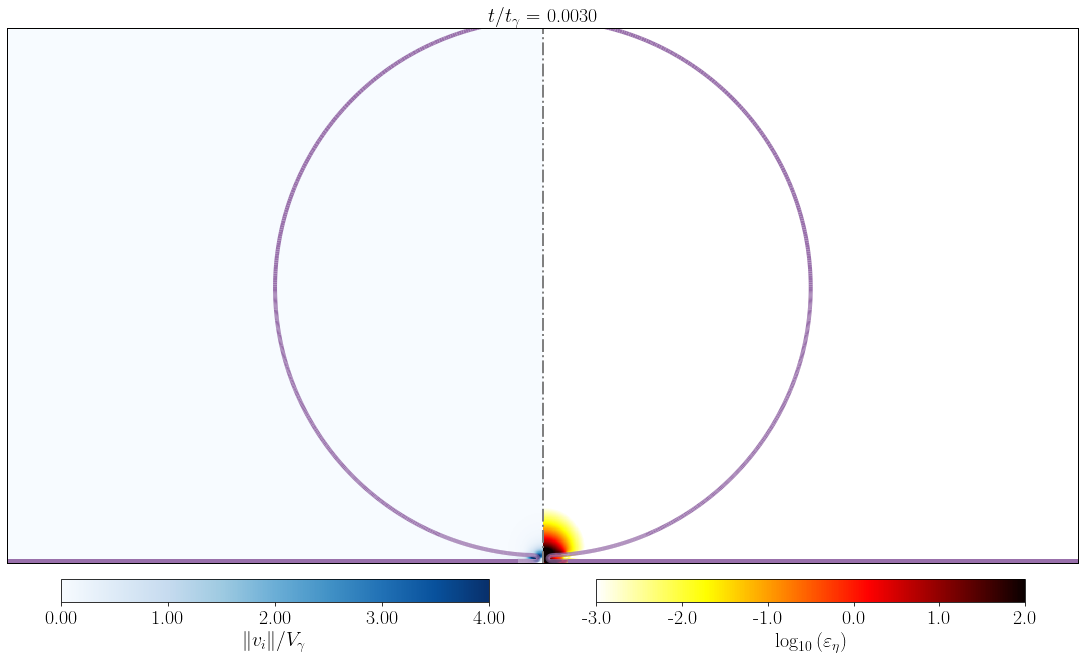

In [7]:
t = 0.003
place = f"intermediate/snapshot-{t:5.4f}"
name = "test1.pdf"

# Get facets and field data from the simulation
segs = gettingFacets(place)
# Plot the snapshot
plot_snapshot(t, place, name, zmin, zmax, rmin, rmax, nr, OhDrop, Oha, segs)

nz is 1024


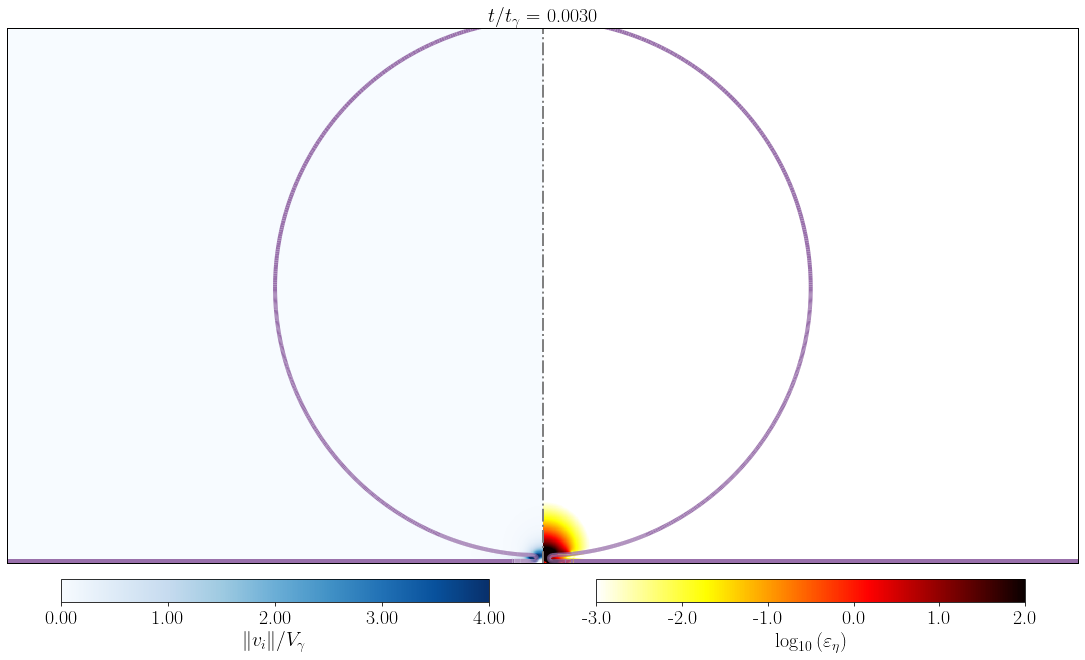

In [8]:
place = "dump"
name = "test2.pdf"

# Get facets and field data from the simulation
segs = gettingFacets(place)
# Plot the snapshot
plot_snapshot(t, place, name, zmin, zmax, rmin, rmax, nr, OhDrop, Oha, segs)